# Compare models (T-S-$\sigma_0$) with observations from Pauthenet et al. (2021) climatology

In [1]:
import xarray as xr
import numpy as np
from glob import glob
import gsw
import time
import xmitgcm as xgcm
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cmocean as cmo
import cosima_cookbook as cc

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dask.distributed import Client
client = Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44377/status,
Dashboard: /proxy/44377/status,Workers: 6
Total threads: 18,Total memory: 220.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41161,Workers: 6
Dashboard: /proxy/44377/status,Total threads: 18
Started: Just now,Total memory: 220.00 GiB
Comm: tcp://127.0.0.1:36817,Total threads: 3
Dashboard: /proxy/45891/status,Memory: 36.67 GiB
Nanny: tcp://127.0.0.1:39351,


List of obs and models and their units. 

| Oservations/Model | Temperature units | Salinity units |
| --- | --- | --- |
| Pauthenet et al. (2021) | in situ temperature [C] | Practical salinity [psu] |
| Schmidtko et a. (2014) | Conservative temperature [C] | Absolute salinity [g/kg] |
| --- | --- | --- |
| ACCESS-OM2-01 |  Conservative temperature [K] | Practical salinity [psu]  |
| BSOSE | Potential temperature [C] | Practical salinity [psu] |
| SOSE | Potential temperature [C] | Practical salinity [psu] |
| ORAS5 | Potential temperature [C] | Salinity [psu]  |
| FESOM-REcoM | Potential temperature [C] | Practical salinity [psu] |



**Note:** to calculate density using `gsw` we need conservative temperature and absolute salinity. So I will convert observations and model data into these units [ CT (degC), AS (g/kg) ]. 

#### Define observational and model data

In [4]:
#obs
# Pauthenet et al. (2021), 1/2 degree resolution
# [temp] = in situ temperature [deg C]
# [salt] = practical salinity [psu]
obsfile = '/g/data/e14/hd4873/obs_data/pauthenetetal2021/TS_Climato_Antarctic60S.nc'
obs = xr.open_dataset(obsfile).mean(dim='time')
# convert units to SA and CT
p = gsw.p_from_z(-obs.depth, obs.lat)
obs['Sal'] = gsw.SA_from_SP(obs.Sal, p, obs.lon, obs.lat)
obs['Temp'] = gsw.CT_from_t(obs.Sal, obs.Temp, p)

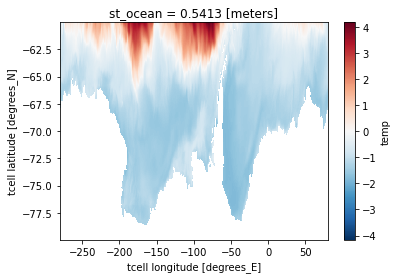

CPU times: user 1min 40s, sys: 19.1 s, total: 1min 59s
Wall time: 9min 47s


In [5]:
%%time
# ACCESS-OM2-01 model, 1/10th deg resolution
data_path = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/'
start_date = '1950-01-01'
end_date = '1970-12-30'
accessfiles = sorted(glob(data_path+'output19*/ocean/ocean.nc')) +\
            sorted(glob(data_path+'output2*/ocean/ocean.nc'))

def preprocess_T(ds):
    ds = ds.sel(yt_ocean=slice(-80,-60)).sel(st_ocean=slice(0,500)).temp
    return ds
def preprocess_S(ds):
    ds = ds.sel(yt_ocean=slice(-80,-60)).sel(st_ocean=slice(0,500)).salt
    return ds
def preprocess_dzt(ds):
    ds = ds.sel(yt_ocean=slice(-80,-60)).sel(st_ocean=slice(0,500)).dzt
    return ds

# [temp] = conservative temperature [K] - but converting to C
# [salt] = practical salinity [psu]
access_T = xr.open_mfdataset(accessfiles, preprocess=preprocess_T).sel(time=slice(start_date, end_date)).temp.mean(dim='time').load() - 273.15
access_S = xr.open_mfdataset(accessfiles, preprocess=preprocess_S).sel(time=slice(start_date, end_date)).salt.mean(dim='time').load()
access_dzt = xr.open_mfdataset(accessfiles, preprocess=preprocess_dzt).sel(time=slice(start_date, end_date)).dzt.mean(dim='time').load()

# convert units to SA
p = gsw.p_from_z(-access_S.st_ocean, access_S.yt_ocean)
access_S = gsw.SA_from_SP(access_S, p,  access_S.xt_ocean,  access_S.yt_ocean)

# plot array to see longitude set-up
access_T[0,:,:].plot()
plt.show()

In [6]:
# ACCESS-OM2-01 model IAF simulation, cycle 3, 1/10th deg resolution
# [temp] = conservative temperature [K] - but converting to C
# [salt] = practical salinity [psu]
session = cc.database.create_session()
expt = '01deg_jra55v140_iaf_cycle3'
start_time = '2005-01-02 00:00:00'
end_time = '2010-12-30 00:00:00'
iaf_access_T = cc.querying.getvar(expt=expt, variable='temp', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=start_time, 
                          end_time=end_time).sel(yt_ocean=slice(-80, -60)).sel(st_ocean=slice(0,500)).mean(dim='time').load()
iaf_access_T = iaf_access_T - 273.15
iaf_access_S = cc.querying.getvar(expt=expt, variable='salt', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=start_time, 
                          end_time=end_time).sel(yt_ocean=slice(-80, -60)).sel(st_ocean=slice(0,500)).mean(dim='time').load()
iaf_access_dzt = cc.querying.getvar(expt=expt, variable='dzt', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=start_time, 
                          end_time=end_time).sel(yt_ocean=slice(-80, -60)).sel(st_ocean=slice(0,500)).mean(dim='time').load()

# convert units to SA
p = gsw.p_from_z(-iaf_access_S.st_ocean, iaf_access_S.yt_ocean)
iaf_access_S = gsw.SA_from_SP(iaf_access_S, p,  iaf_access_S.xt_ocean,  iaf_access_S.yt_ocean)

In [9]:
#SOSE model, 1/12 deg resolution
#[temp] = potential temperature [C]
#[salt] = practical salinity [psu]
sose_data_path_T = '/g/data/e14/hd4873/model_data/sose/so12_i0_year20052010_Theta.nc'
sose_data_path_S = '/g/data/e14/hd4873/model_data/sose/so12_i0_year20052010_Salt.nc'
sose_T = xr.open_dataset(sose_data_path_T)
sose_T = xr.DataArray(sose_T.theta_mean.data, coords=[("z", sose_T.depth.data), ("yc", sose_T.lat.data),("xc", sose_T.lon.data), ])
sose_S = xr.open_dataset(sose_data_path_S)
sose_S = xr.DataArray(sose_S.salt_mean.data, coords=[("z", sose_S.depth.data), ("yc", sose_S.lat.data),("xc", sose_S.lon.data), ])

# convert units to SA and CT
p = gsw.p_from_z(-sose_S.z, sose_S.yc)
sose_S = gsw.SA_from_SP(sose_S, p, sose_S.xc, sose_S.yc)
sose_T = gsw.CT_from_pt(sose_S, sose_T)

# plot array to see longitude set-up
#sose_T[0,:,:].plot()
#plt.show()

In [10]:
%%time
# ORAS5 (1/4 degree resolution) comprises an ensemble of 5 runs with different perturbations to the initial conditions, 
# forcings, and observations (https://os.copernicus.org/articles/15/779/2019/). 

# We will read in the temp and salinity for each ensemble and then take these average of these at the end.
# https://www.cen.uni-hamburg.de/icdc/data/ocean/easy-init-ocean/ecmwf-oras5.html

sim = np.arange(0,5,1)
sim_name = ['opa0','opa1','opa2','opa3','opa4']
oras5_data_path = '/scratch/e14/hd4873/oras5/ORCA025/'
# use same period as SOSE simulation
start_time = '2005-01-01'
end_time = '2010-12-30'

# define preprocess functions to limit model domain when reading in
def preprocess_T(ds):
    ds = ds.sel(deptht=slice(0,700)).sel(y=slice(0,200)).votemper
    return ds
def preprocess_S(ds):
    ds = ds.sel(deptht=slice(0,700)).sel(y=slice(0,200)).vosaline
    return ds

# loop through enemble members
for i, s in enumerate(sim):
    print(i,sim_name[i])
    # read in model files ----------------------------------------
    oras5_Tfiles = sorted(glob(oras5_data_path+f'votemper/{sim_name[i]}/votemper_*.nc')) 
    oras5_Sfiles = sorted(glob(oras5_data_path+f'vosaline/{sim_name[i]}/vosaline_*.nc')) 
    
    # read in T and S data
    oras5_T = xr.open_mfdataset(oras5_Tfiles, preprocess=preprocess_T).drop_vars(['nav_lat','nav_lon']).sel(time_counter=slice(start_time,end_time)).mean(dim='time_counter').load()
    oras5_Tref = xr.open_mfdataset(oras5_Tfiles[0:1], preprocess=preprocess_T)
    oras5_S = xr.open_mfdataset(oras5_Sfiles, preprocess=preprocess_S).drop_vars(['nav_lat','nav_lon']).sel(time_counter=slice(start_time,end_time)).mean(dim='time_counter').load()
    oras5_T = oras5_T['votemper']
    oras5_S = oras5_S['vosaline']
    
    # Wrap ORAS5 data so that it matches obs (-180 to 180).
    # extract lat and lon from reference array
    y =  oras5_Tref.nav_lat[:,0].values
    x =  oras5_Tref.nav_lon[0,:].values
    #print(x[1148:1151])
    x[429] = -180.
    x[1149] = 0
    new_x = np.sort(np.concatenate((x[429:],x[:429]))) # sorted lon
    # assign lat and lon as coordinates labelled x and y for grid cell centers
    oras5_T = oras5_T.assign_coords({"y": y, "x": x})
    oras5_S = oras5_S.assign_coords({"y": y, "x": x})
    # now concatenate temp and salinity so that it goes from -180 to 180 like pauthenet data
    oras5_T = xr.concat((oras5_T[:,:,429:], oras5_T[:,:,0:429]), dim='x')#.drop_vars(['nav_lat', 'nav_lon'])
    oras5_S = xr.concat((oras5_S[:,:,429:], oras5_S[:,:,0:429]), dim='x')#.drop_vars(['nav_lat', 'nav_lon'])
    # reassign x as the newly ordered lon array (otherwise matplotlib complains that x dimension is not sorted in increasing manner)
    oras5_T["x"] = new_x
    oras5_S["x"] = new_x

    # convert units to SA and CT
    p = gsw.p_from_z(-oras5_S.deptht, oras5_S.y)
    oras5_S = gsw.SA_from_SP(oras5_S, p, oras5_S.x, oras5_S.y)
    oras5_T = gsw.CT_from_pt(oras5_S, oras5_T)
    
    if i == 0:
        oras5_T0 = oras5_T.copy(deep=True)
        oras5_S0 = oras5_S.copy(deep=True)
    elif i ==1:
        oras5_T1 = oras5_T.copy(deep=True)
        oras5_S1 = oras5_S.copy(deep=True)
    elif i ==2:
        oras5_T2 = oras5_T.copy(deep=True)
        oras5_S2 = oras5_S.copy(deep=True)
    elif i ==3:
        oras5_T3 = oras5_T.copy(deep=True)
        oras5_S3 = oras5_S.copy(deep=True)
    else:
        oras5_T4 = oras5_T.copy(deep=True)
        oras5_S4 = oras5_S.copy(deep=True)
        
oras5_T = (oras5_T0 + oras5_T1 + oras5_T2 + oras5_T3 + oras5_T4)/5.
oras5_S = (oras5_S0 + oras5_S1 + oras5_S2 + oras5_S3 + oras5_S4)/5.

# reassign coordinates. 
oras5_S = xr.DataArray(oras5_S.data, coords=[("zc", oras5_S.deptht.data), ("yc", oras5_S.y.data),("xc", oras5_S.x.data), ])
oras5_T = xr.DataArray(oras5_T.data, coords=[("zc", oras5_T.deptht.data), ("yc", oras5_T.y.data),("xc", oras5_T.x.data), ])

#oras5_T[0,:,:].plot()
#plt.show()

0 opa0
1 opa1
2 opa2
3 opa3
4 opa4
CPU times: user 2min 50s, sys: 23.9 s, total: 3min 14s
Wall time: 7min 57s


#### Wrap model data so it matches obs

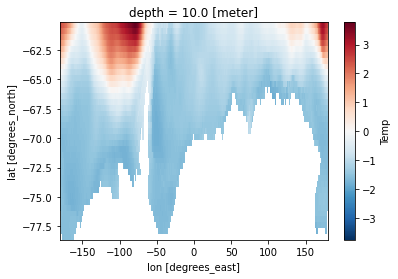

In [11]:
# Plot obs grid for reference
obs.Temp[:,:,0].T.plot()
plt.show()

Wrap **RYF ACCESS-OM2-01** data so that it matches obs (-180 to 180).

In [12]:
# make xt_ocean values from -180 to 180
xt_ocean = access_T.xt_ocean.values
xt_ocean[xt_ocean<-180] = xt_ocean[xt_ocean<-180]+360
# replace xt_ocean coordinate values with these modified xt_ocean values
access_T['xt_ocean'] = xt_ocean
access_S['xt_ocean'] = xt_ocean
access_dzt['xt_ocean'] = xt_ocean
# now concatenate temp and salinity so that it goes from -180 to 180 like pauthenet data
access_T = xr.concat((access_T[:,:,1000:], access_T[:,:,0:1000]), dim='xt_ocean')
access_S = xr.concat((access_S[:,:,1000:], access_S[:,:,0:1000]), dim='xt_ocean')
access_dzt = xr.concat((access_dzt[:,:,1000:], access_dzt[:,:,0:1000]), dim='xt_ocean')
#access_T[0,:,:].plot()
#plt.show()

Wrap **IAF ACCESS-OM2-01** data so that it matches obs (-180 to 180).

In [13]:
# make xt_ocean values from -180 to 180
xt_ocean = iaf_access_T.xt_ocean.values
xt_ocean[xt_ocean<-180] = xt_ocean[xt_ocean<-180]+360
# replace xt_ocean coordinate values with these modified xt_ocean values
iaf_access_T['xt_ocean'] = xt_ocean
iaf_access_S['xt_ocean'] = xt_ocean
iaf_access_dzt['xt_ocean'] = xt_ocean
# now concatenate temp and salinity so that it goes from -180 to 180 like pauthenet data
iaf_access_T = xr.concat((iaf_access_T[:,:,1000:], iaf_access_T[:,:,0:1000]), dim='xt_ocean')
iaf_access_S = xr.concat((iaf_access_S[:,:,1000:], iaf_access_S[:,:,0:1000]), dim='xt_ocean')
iaf_access_dzt = xr.concat((iaf_access_dzt[:,:,1000:], iaf_access_dzt[:,:,0:1000]), dim='xt_ocean')
#iaf_access_T[0,:,:].plot()
#plt.show()

Wrap **SOSE** data so that it matches obs (-180 to 180).

In [14]:
XC = sose_T.xc.values
XC[XC>180] = XC[XC>180]-360
# replace XC coordinate values with these modified xt_ocean values
sose_T['xc'] = XC
sose_S['xc'] = XC
# now concatenate temp and salinity so that it goes from -180 to 180 like pauthenet data
sose_T = xr.concat((sose_T[:,:,2160:], sose_T[:,:,0:2160]), dim='xc')
sose_S = xr.concat((sose_S[:,:,2160:], sose_S[:,:,0:2160]), dim='xc')
#sose_T[0,:,:].plot()
#plt.show()

#### Calculate density (sigma0)

In [15]:
# observations
obs['sig0'] = gsw.sigma0(obs.Sal, obs.Temp)
# Acces RYF
access_sig0 = gsw.sigma0(access_S, access_T)
# Access IAF
iaf_access_sig0 = gsw.sigma0(iaf_access_S, iaf_access_T)
# SOSE
sose_sig0 = gsw.sigma0(sose_S, sose_T)
# ORAS5
oras5_sig0 = gsw.sigma0(oras5_S, oras5_T)

#### Calculate cell thicknesses for SOSE and ORAS5. 

Read in SOSE U and V to get left grid cell data. 

In [19]:
sose_data_path_U = '/g/data/e14/hd4873/model_data/sose/so12_i0_year20052010_Uvel_fixed.nc'
sose_data_path_V = '/g/data/e14/hd4873/model_data/sose/so12_i0_year20052010_Vvel_fixed.nc'
sose_U = xr.open_dataset(sose_data_path_U)
# resplace ilon and ilat dimensions with  data rather than using ilon and ilat
sose_U = xr.DataArray(sose_U.uvel_mean.data, coords=[("z", sose_U.depth.data), ("yc", sose_U.lat.data),("xg", sose_U.lon.data), ])
#sose_U = sose_U.sel(yc=slice(-82,-59)).sel(z=slice(z_range[0],z_range[1]+100)).load()
sose_V = xr.open_dataset(sose_data_path_V)
sose_V = xr.DataArray(sose_V.vvel_mean.data, coords=[("z", sose_V.depth.data), ("yg", sose_V.lat.data),("xc", sose_V.lon.data), ])
#sose_V = sose_V.sel(yg=slice(-82,-59)).sel(z=slice(z_range[0],z_range[1]+100)).load()

# concatenate U and V to match obs and sose_T/sose_S data. 
XC = sose_V.xc.values
XC[XC>180] = XC[XC>180]-360
XG = sose_U.xg.values
XG[XG>180] = XG[XG>180]-360
XG[2160] = -180.
# replace XC/XG coordinate values with these modified values
sose_U['xg'] = XG
sose_V['xc'] = XC
# now concatenate temp and salinity so that it goes from -180 to 180 like pauthenet data
sose_U = xr.concat((sose_U[:,:,2160:], sose_U[:,:,0:2160]), dim='xg')
sose_V = xr.concat((sose_V[:,:,2160:], sose_V[:,:,0:2160]), dim='xc')

# combine U, V, T, S into one dataset
sose_ds = xr.Dataset({'sose_u':sose_U,
                        'sose_v':sose_V,#.isel(yg = slice(None,-1)),
                        'sose_t':sose_T,#.isel(yg = slice(None,-1)),
                        'sose_s':sose_S,})

# Generate 'full' dataset, which includes additional coordinate `z_left` and appropriate attributes.
sose_full = generate_grid_ds(sose_ds, {'Z':'z'})

# Create grid object
grid = Grid(sose_full, periodic=['X','Y'])

# Calculate vertical distances located on the cellboundary
sose_full.coords['dzc'] = grid.diff(sose_full.z, 'Z', boundary='fill')
# Calculate vertical distances located on the cellcenter
sose_full.coords['dzt'] = grid.diff(sose_full.z_left, 'Z', boundary='fill')

# Now calculating the depth-weighted average is easy using dzt. 

Read in ORAS5 U and V to get right grid cell data. 

In [20]:
sim = np.arange(0,5,1)
sim_name = ['opa1']
oras5_data_path = '/scratch/e14/hd4873/oras5/ORCA025/'
# use same period as SOSE simulation
start_time = '2005-01-01'
end_time = '2010-12-30'

# define preprocess functions to limit model domain when reading in
def preprocess_U(ds):
    ds = ds.sel(y=slice(0,200)).sel(depthu=slice(0,700)).vozocrtx
    return ds
def preprocess_V(ds):
    ds = ds.sel(y=slice(0,200)).sel(depthv=slice(0,700)).vomecrty
    return ds

oras5_Ufiles = sorted(glob(oras5_data_path+f'vozocrtx/{sim_name[0]}/vozocrtx_*.nc')) 
oras5_Vfiles = sorted(glob(oras5_data_path+f'vomecrty/{sim_name[0]}/vomecrty_*.nc')) 

oras5_U = xr.open_mfdataset(oras5_Ufiles, preprocess=preprocess_U).drop_vars(['nav_lat','nav_lon']).sel(time_counter=slice(start_time, end_time)).mean(dim='time_counter').load()
oras5_Uref = xr.open_mfdataset(oras5_Ufiles[0:1]).sel(y=slice(0,200)).vozocrtx
oras5_V = xr.open_mfdataset(oras5_Vfiles, preprocess=preprocess_V).drop_vars(['nav_lat','nav_lon']).sel(time_counter=slice(start_time, end_time)).mean(dim='time_counter').load()
oras5_Vref = xr.open_mfdataset(oras5_Vfiles[0:1], preprocess=preprocess_V).vomecrty
oras5_U = oras5_U['vozocrtx']
oras5_V = oras5_V['vomecrty']

# replace x and y indices with equivalent lat and lons
latu, lonu = oras5_Uref.nav_lat[:,0].values, oras5_Uref.nav_lon[0,:].values
latv, lonv = oras5_Vref.nav_lat[:,0].values, oras5_Vref.nav_lon[0,:].values
oras5_U['x'] = lonu
oras5_U['y'] = latu
oras5_V['x'] = lonv
oras5_V['y'] = latv

# reassign coordinates for xgcm. 
oras5_U = xr.DataArray(oras5_U.data, coords=[("zc", oras5_U.depthu.data), ("yc", oras5_U.y.data),("xf", oras5_U.x.data), ])
oras5_V = xr.DataArray(oras5_V.data, coords=[("zc", oras5_V.depthv.data), ("yf", oras5_V.y.data),("xc", oras5_V.x.data), ])

# Wrap ORAS5 data so that it matches obs (-180 to 180).
# extract lat and lon from reference array
y =  oras5_U.yc.values
x =  oras5_U.xf.values
x[1149] = 0
new_x = np.sort(np.concatenate((x[429:],x[:429]))) # sorted lon
# now concatenate U so that it goes from -180 to 180 like pauthenet data
oras5_U = xr.concat((oras5_U[:,:,429:], oras5_U[:,:,0:429]), dim='xf')
# reassign x as the newly ordered lon array (otherwise matplotlib complains that x dimension is not sorted in increasing manner)
oras5_U["xf"] = new_x

y =  oras5_V.yf.values
vx =  oras5_V.xc.values
vx[429] = -180.
vx[1149] = 0
new_vx = np.sort(np.concatenate((vx[429:],vx[:429]))) # sorted lon
# now concatenate V so that it goes from -180 to 180 like pauthenet data
oras5_V = xr.concat((oras5_V[:,:,429:], oras5_V[:,:,0:429]), dim='xc')
# reassign x as the newly ordered lon array (otherwise matplotlib complains that x dimension is not sorted in increasing manner)
oras5_V["xc"] = new_vx

# combine U, V, T and S into one dataset.
oras5_ds = xr.Dataset({'oras5_u':oras5_U,
                        'oras5_v':oras5_V,#.isel(yg = slice(None,-1)),
                        'oras5_t':oras5_T,#.isel(yg = slice(None,-1)),
                        'oras5_s':oras5_S,})

# Generate 'full' dataset, which includes additional coordinate `z_left` and appropriate attributes.
oras5_full = generate_grid_ds(oras5_ds, {'Z':'zc'})

# Create grid object
grid = Grid(oras5_full, periodic=['X','Y'])

# Calculate vertical distances located on the cellboundary
oras5_full.coords['dzc'] = grid.diff(oras5_full.zc, 'Z', boundary='fill')
# Calculate vertical distances located on the cellcenter
oras5_full.coords['dzt'] = grid.diff(oras5_full.zc_left, 'Z', boundary='fill')

**access om2**: access_dzt variable  (3D variable)  
**bsose**:  bsose_T.drF (1D) * bsose_T.hFacW (2D)  
**sose**: newly created dzt variable  
**oras5**: newly created dzt variable  

#### Define function to interpolate obs data onto model grids

In [21]:
import xesmf as xe

In [22]:
def regrid_obs(obs_mean,model_grid):
    regridder = xe.Regridder(obs, model_grid, 'conservative', periodic=True)
    #regridder.clean_weight_file()
    obs_regrid = regridder(obs_mean)
    return obs_regrid

# define model output grids for xesmf
access_grid_out = xr.Dataset({"lat": (["lat"], access_T.yt_ocean.data),
                             "lon": (["lon"], access_T.xt_ocean.data),
                            })
sose_grid_out = xr.Dataset({"lat": (["lat"], sose_full.yc.data),
                            "lon": (["lon"], sose_full.xc.data),
                            })
oras5_grid_out = xr.Dataset({"lat": (["lat"], oras5_full.yc.data),
                             "lon": (["lon"], oras5_full.xc.data),
                            })

Take the mean of observations over the depth range of interest. Obs are defined every 2m vertically so do not need to be weighted. 

In [23]:
z_range=[10,380]

# xesm doesn't want longitude as first dimension, so make sure to transpose the observations 
obs_mean = obs.sel(depth=slice(z_range[0],z_range[1])).mean(dim='depth').transpose()

Now regrid observations onto the model grids. 

In [ ]:
%%time
obs_access = regrid_obs(obs_mean,access_grid_out)
obs_sose = regrid_obs(obs_mean,sose_grid_out)
obs_oras5 = regrid_obs(obs_mean,oras5_grid_out)

#### Calculate anomalies. 

In [34]:
%%time
# depth range
z_range = [10,380]

#access ryf ---------
# temp
# mask obs for bottom level (within z range slice) of model
access_bottom_mask = access_T.sel(st_ocean=slice(z_range[0],z_range[1])).isel(st_ocean=-1)
obs_access = obs_access.where(access_bottom_mask.values >= -10, np.nan)
cell_thickness = access_dzt.sel(st_ocean=slice(z_range[0],z_range[1]))
temp_slice = (access_T.sel(st_ocean=slice(z_range[0],z_range[1]))*(cell_thickness/cell_thickness.sum(dim='st_ocean'))).sum(dim='st_ocean')
access_anomT = temp_slice - obs_access.Temp.values
# psal 
salt_slice = (access_S.sel(st_ocean=slice(z_range[0],z_range[1]))*(cell_thickness/cell_thickness.sum(dim='st_ocean'))).sum(dim='st_ocean')
access_anomS = salt_slice - obs_access.Sal.values
# rho
rho_slice = (access_sig0.sel(st_ocean=slice(z_range[0],z_range[1]))*(cell_thickness.values/cell_thickness.sum(dim='st_ocean').values)).sum(dim='st_ocean')
rho_slice = rho_slice.where(rho_slice > 0, np.nan)
access_anomRho = rho_slice - obs_access.sig0.values

#access iaf ---------
# temp
# mask obs for bottom level (within z range slice) of model
access_bottom_mask = iaf_access_T.sel(st_ocean=slice(z_range[0],z_range[1])).isel(st_ocean=-1)
obs_access_iaf = obs_access.where(access_bottom_mask.values >= -10, np.nan)
cell_thickness = iaf_access_dzt.sel(st_ocean=slice(z_range[0],z_range[1]))
temp_slice = (iaf_access_T.sel(st_ocean=slice(z_range[0],z_range[1]))*(cell_thickness/cell_thickness.sum(dim='st_ocean'))).sum(dim='st_ocean')
iaf_access_anomT = temp_slice - obs_access.Temp.values
# psal 
salt_slice = (iaf_access_S.sel(st_ocean=slice(z_range[0],z_range[1]))*(cell_thickness/cell_thickness.sum(dim='st_ocean'))).sum(dim='st_ocean')
iaf_access_anomS = salt_slice - obs_access.Sal.values
# rho
rho_slice = (iaf_access_sig0.sel(st_ocean=slice(z_range[0],z_range[1]))*(cell_thickness.values/cell_thickness.sum(dim='st_ocean').values)).sum(dim='st_ocean')
rho_slice = rho_slice.where(rho_slice > 0, np.nan)
iaf_access_anomRho = rho_slice - obs_access.sig0.values

##sose ----------
sose_bottom_mask = sose_T.sel(z=slice(z_range[0],z_range[1])).isel(z=-1)
obs_sose = obs_sose.where(sose_bottom_mask.values >= -10, np.nan)
## temp
temp_slice_weighted = (sose_full.sose_t.sel(z=slice(z_range[0],z_range[1])) * sose_full.dzt.sel(z=slice(z_range[0],z_range[1]))).sum('z') / sose_full.dzt.sel(z=slice(z_range[0],z_range[1])).sum('z')
sose_anomT = temp_slice_weighted - obs_sose.Temp.values
## psal
psal_slice_weighted = (sose_full.sose_s.sel(z=slice(z_range[0],z_range[1])) * sose_full.dzt.sel(z=slice(z_range[0],z_range[1]))).sum('z') / sose_full.dzt.sel(z=slice(z_range[0],z_range[1])).sum('z')
sose_anomS = psal_slice_weighted - obs_sose.Sal.values
## rho
rho_slice_weighted = (sose_sig0.sel(z=slice(z_range[0],z_range[1])) * sose_full.dzt.sel(z=slice(z_range[0],z_range[1]))).sum('z') / sose_full.dzt.sel(z=slice(z_range[0],z_range[1])).sum('z')
sose_anomRho = rho_slice_weighted - obs_sose.sig0.values


# oras5 ----------
oras5_bottom_mask = oras5_T.sel(zc=slice(z_range[0],z_range[1])).isel(zc=-1)
obs_oras5 = obs_oras5.where(oras5_bottom_mask.values >= -10, np.nan)
# temp
temp_slice_weighted = (oras5_full.oras5_t.sel(zc=slice(z_range[0],z_range[1])) * oras5_full.dzt.sel(zc=slice(z_range[0],z_range[1]))).sum('zc') / oras5_full.dzt.sel(zc=slice(z_range[0],z_range[1])).sum('zc')
oras5_anomT = temp_slice_weighted - obs_oras5.Temp.values
## psal
psal_slice_weighted = (oras5_full.oras5_s.sel(zc=slice(z_range[0],z_range[1])) * oras5_full.dzt.sel(zc=slice(z_range[0],z_range[1]))).sum('zc') / oras5_full.dzt.sel(zc=slice(z_range[0],z_range[1])).sum('zc')
oras5_anomS = psal_slice_weighted - obs_oras5.Sal.values
## rho
rho_slice_weighted = (oras5_sig0.sel(zc=slice(z_range[0],z_range[1])) * oras5_full.dzt.sel(zc=slice(z_range[0],z_range[1]))).sum('zc') / oras5_full.dzt.sel(zc=slice(z_range[0],z_range[1])).sum('zc')
oras5_anomRho = rho_slice_weighted - obs_oras5.sig0.values


CPU times: user 5.96 s, sys: 254 ms, total: 6.21 s
Wall time: 5.5 s


#### Define figure functions.  

In [43]:
# topography data for plotting:
htfile = data_path + 'output196/ocean/ocean_grid.nc'
ht = xr.open_dataset(htfile).ht.sel(yt_ocean=slice(-90,-55)).load()
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

# define circle 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
subplot_titles = ['Observations',
                  'ACCESS-OM2-01 \nRYF model years 50-70',
                  'ACCESS-OM2-01 \nIAF 2005-2010',
                  'SOSE \n2005-2010','ORAS5 \n2005-2010']
subplot_titles_full = np.repeat(subplot_titles, 3)
subplot_labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)','m)','n)','o)']
fontsize=16

# define obs land mask
obs_land_mask = obs.Temp[:,:,0].fillna(1)
obs_land_mask_masked = obs_land_mask.where(obs_land_mask == 1)

def map_elements(axes):
    for i, ax in enumerate(axes.flatten()):
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
        ax.set_extent([-280, 80, -90, -60.5], ccrs.PlateCarree())
        ax.text(0.1, 0.95, subplot_labels[i],fontsize=20, fontweight='bold',transform = ax.transAxes)
        ax.text(0.55, 0.5, subplot_titles_full[i],fontsize=14, ha='center',va='center',transform = ax.transAxes)
              
def plot_colorbar(fig,axes_loc,cb_item,label):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'vertical',extend = 'both', shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=3)
    cbar.ax.tick_params(labelsize=14)
    
def plot_var_colorbar(fig,axes_loc,cb_item,label):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'horizontal',extend = 'both', shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=3)
    cbar.ax.tick_params(labelsize=14)
    cbaxes.xaxis.set_ticks_position('top')
    cbaxes.xaxis.set_label_position('top')

def plot_anom_colorbar(fig,axes_loc,cb_item,label):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'horizontal',extend = 'both', shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=3)
    cbar.ax.tick_params(labelsize=14)
    cbaxes.xaxis.set_ticks_position('bottom')
    cbaxes.xaxis.set_label_position('bottom')
    
# define figure function
def figure_ts_fixedz(z_level):
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(2,4,figsize=(23,12),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.02, hspace=0.01)
    map_elements(axes)
    vminT, vmaxT = -2, 3
    vminS, vmaxS = 33.8, 34.6
    cmapT, cmapS = cmo.cm.thermal, cmo.cm.haline
    # plot observations
    cb_varT = axes[0,0].pcolormesh(obs.Temp.lon,obs.Temp.lat,obs.Temp.sel(depth=z_level, method='nearest').T,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, 
                   transform = ccrs.PlateCarree())
    cb_varS = axes[1,0].pcolormesh(obs.Sal.lon,obs.Sal.lat,obs.Sal.sel(depth=z_level, method='nearest').T,
               cmap = cmapS, vmin=vminS, vmax=vmaxS, 
               transform = ccrs.PlateCarree())
    plot_colorbar(fig,[0.08, 0.55, 0.010, 0.3],cb_varT,'Pot. Temperature ($^\circ$C)')
    plot_colorbar(fig,[0.08, 0.16, 0.010, 0.3],cb_varS,'Practical salinity (psu)')
    return fig, axes

# define figure function
def figure_ts_zrange(z_range):
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(2,4,figsize=(23,12),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.02, hspace=0.01)
    map_elements(axes)
    vminT, vmaxT = -2, 3
    vminS, vmaxS = 34.1, 34.8
    cmapT, cmapS = cmo.cm.thermal, cmo.cm.haline
    # plot observations
    # these are located vertically every 2m so a simple mean will suffice (depth weighting not required) 
    cb_varT = axes[0,0].pcolormesh(obs.Temp.lon,obs.Temp.lat,obs.Temp.sel(depth=slice(z_range[0],z_range[1])).mean(dim='depth').T,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, 
                   transform = ccrs.PlateCarree())
    cb_varS = axes[1,0].pcolormesh(obs.Sal.lon,obs.Sal.lat,obs.Sal.sel(depth=slice(z_range[0],z_range[1])).mean(dim='depth').T,
               cmap = cmapS, vmin=vminS, vmax=vmaxS, 
               transform = ccrs.PlateCarree())
    plot_colorbar(fig,[0.08, 0.55, 0.010, 0.3],cb_varT,'Conservative temperature (\u00b0C)')
    plot_colorbar(fig,[0.08, 0.16, 0.010, 0.3],cb_varS,'Absolute salinity (g/kg)')
    return fig, axes

# define figure function
def figure_tsrho_zrange(z_range):
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(5,3,figsize=(16,26),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    map_elements(axes)
    vminT, vmaxT = -2, 3
    vminS, vmaxS = 34.1, 34.8
    vminRho, vmaxRho = 27.1, 27.9
    cmapT, cmapS, cmapRho = cmo.cm.thermal, cmo.cm.haline, cmo.cm.dense
    # plot observations
    # these are located vertically every 2m so a simple mean will suffice (depth weighting not required) 
    cb_varT = axes[0,0].pcolormesh(obs.Temp.lon,obs.Temp.lat,obs.Temp.sel(depth=slice(z_range[0],z_range[1])).mean(dim='depth').T,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, 
                   transform = ccrs.PlateCarree())
    cb_varS = axes[0,1].pcolormesh(obs.Sal.lon,obs.Sal.lat,obs.Sal.sel(depth=slice(z_range[0],z_range[1])).mean(dim='depth').T,
               cmap = cmapS, vmin=vminS, vmax=vmaxS, 
               transform = ccrs.PlateCarree())
    cb_varRho = axes[0,2].pcolormesh(obs.sig0.lon,obs.sig0.lat,obs.sig0.sel(depth=slice(z_range[0],z_range[1])).mean(dim='depth').T,
               cmap = cmapRho, vmin=vminRho, vmax=vmaxRho, 
               transform = ccrs.PlateCarree())
    
    plot_var_colorbar(fig,[0.164, 0.89, 0.18, 0.010],cb_varT,'Conservative temperature (\u00b0C)')
    plot_var_colorbar(fig,[0.424, 0.89, 0.18, 0.010],cb_varS,'Absolute salinity (g/kg)')
    plot_var_colorbar(fig,[0.682, 0.89, 0.18, 0.010],cb_varRho,r'$\sigma_{0}$ (kg/m$^{-3}$)')
    
    return fig,axes

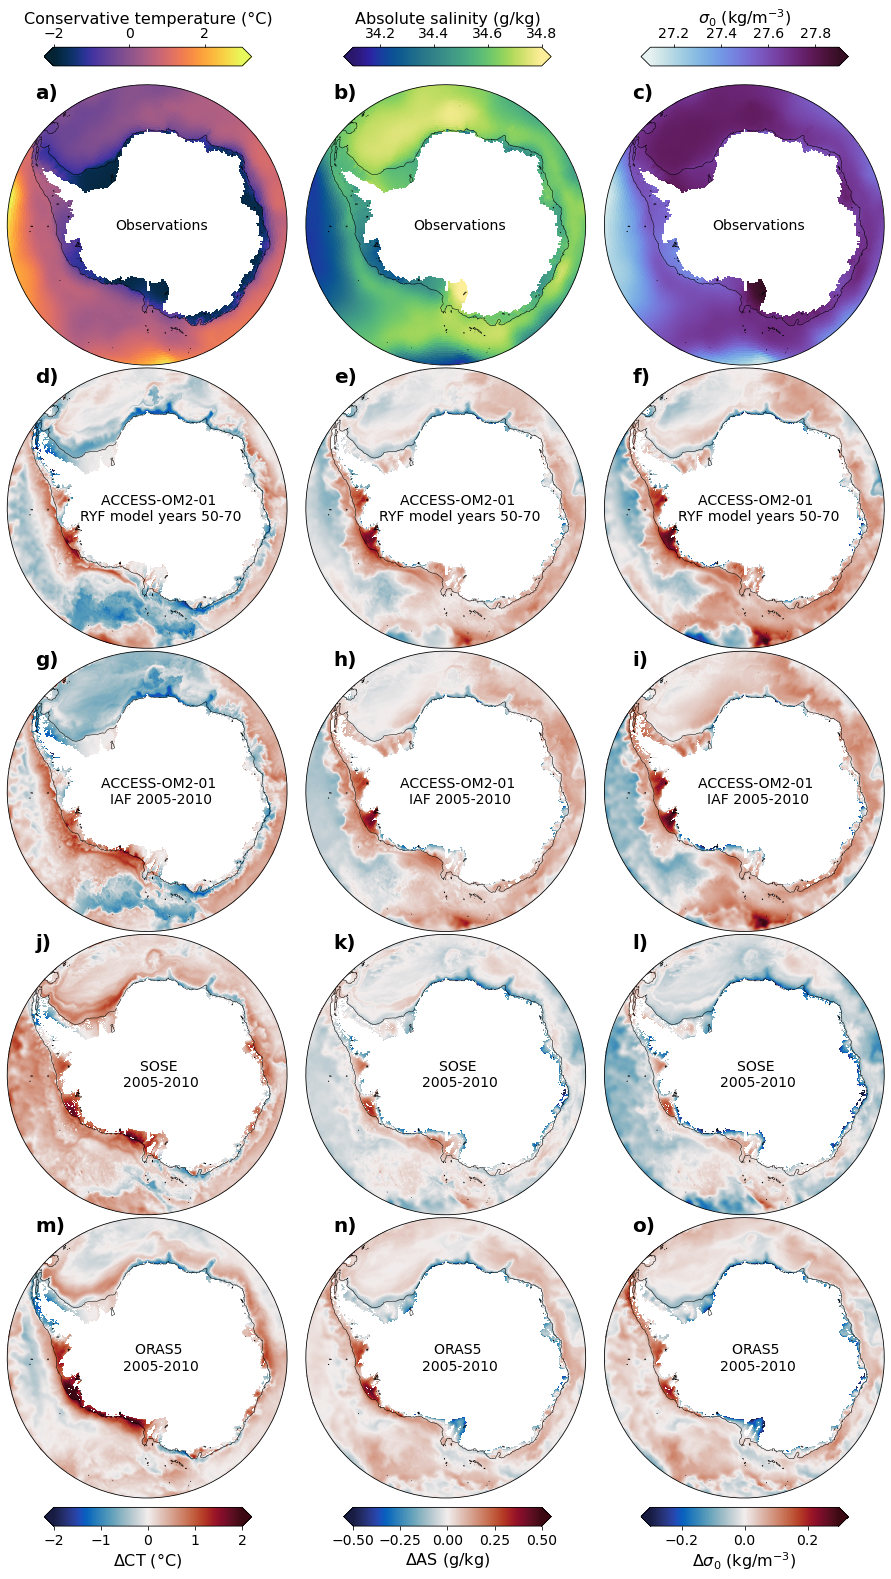

2022-10-13 21:50:48,593 - distributed.worker - WARNING - Heartbeat to scheduler failed
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/comm/tcp.py", line 229, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/worker.py", line 1151, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/utils_comm.py", line 383, in retry_operation
    return await retry(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/utils_comm.py", line 368, in retry
    return await coro()
  File "/g/data

In [44]:
fig, axes = figure_tsrho_zrange(z_range)

vminaT, vmaxaT = -2,2
vminaS, vmaxaS = -0.5,0.5
vminaRho, vmaxaRho = -0.3,0.3
cmapA = cmo.cm.balance

# TEMP anomalies ----
# ryf access anom
cb_anom = axes[1][0].pcolormesh(access_anomT.xt_ocean, access_anomT.yt_ocean, access_anomT, 
                                cmap=cmapA,vmin=vminaT,vmax=vmaxaT,transform = ccrs.PlateCarree())
# iaf access 
cb_anom = axes[2][0].pcolormesh(iaf_access_anomT.xt_ocean, iaf_access_anomT.yt_ocean, iaf_access_anomT, 
                                cmap=cmapA,vmin=vminaT,vmax=vmaxaT,transform = ccrs.PlateCarree())
# sose 
axes[3][0].pcolormesh(sose_anomT.xc, sose_anomT.yc, sose_anomT,
                      cmap=cmapA,vmin=vminaT,vmax=vmaxaT,transform = ccrs.PlateCarree())
#oras5 
axes[4][0].pcolormesh(oras5_anomT.xc, oras5_anomT.yc, oras5_anomT,
                      cmap=cmapA,vmin=vminaT,vmax=vmaxaT,transform = ccrs.PlateCarree())
plot_anom_colorbar(fig,[0.164, 0.11, 0.18, 0.010],cb_anom,'$\Delta$CT (\u00b0C)')

# SALT anomalies ----
# access 
cb_anom = axes[1][1].pcolormesh(access_anomS.xt_ocean, access_anomS.yt_ocean, access_anomS, 
                                cmap=cmapA,vmin=vminaS,vmax=vmaxaS,transform = ccrs.PlateCarree())
axes[2][1].pcolormesh(iaf_access_anomS.xt_ocean, iaf_access_anomS.yt_ocean, iaf_access_anomS, 
                                cmap=cmapA,vmin=vminaS,vmax=vmaxaS,transform = ccrs.PlateCarree())
# sose 
axes[3][1].pcolormesh(sose_anomS.xc, sose_anomS.yc, sose_anomS,
                      cmap=cmapA,vmin=vminaS,vmax=vmaxaS,transform = ccrs.PlateCarree())
#oras5 
axes[4][1].pcolormesh(oras5_anomS.xc, oras5_anomS.yc, oras5_anomS,
                      cmap=cmapA,vmin=vminaS,vmax=vmaxaS,transform = ccrs.PlateCarree())
plot_anom_colorbar(fig,[0.424, 0.11, 0.18, 0.010],cb_anom,'$\Delta$AS (g/kg)')


# density anomalies ----
# access 
cb_anom = axes[1][2].pcolormesh(access_anomRho.xt_ocean, access_anomRho.yt_ocean, access_anomRho, 
                                cmap=cmapA,vmin=vminaRho,vmax=vmaxaRho,transform = ccrs.PlateCarree())
axes[2][2].pcolormesh(iaf_access_anomRho.xt_ocean, iaf_access_anomRho.yt_ocean, iaf_access_anomRho, 
                                cmap=cmapA,vmin=vminaRho,vmax=vmaxaRho,transform = ccrs.PlateCarree())
# sose 
axes[3][2].pcolormesh(sose_anomRho.xc, sose_anomRho.yc, sose_anomRho,
                      cmap=cmapA,vmin=vminaRho,vmax=vmaxaRho,transform = ccrs.PlateCarree())
#oras5 
axes[4][2].pcolormesh(oras5_anomRho.xc, oras5_anomRho.yc, oras5_anomRho,
                      cmap=cmapA,vmin=vminaRho,vmax=vmaxaRho,transform = ccrs.PlateCarree())
plot_anom_colorbar(fig,[0.682, 0.11, 0.18, 0.010],cb_anom,'$\Delta$$\sigma_{0}$ (kg/m$^{-3}$)')

# save figure
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
figfilename = datadir+f'FigS1_model_obs_TSrho_comparison_zrange_{int(z_range[0])}-{int(z_range[-1])}m.jpg'
fig.savefig(figfilename, bbox_inches='tight', dpi=300)
plt.show()

# Schmidtko et al. (2014)

In [ ]:
# Schmidtko et al. (2014)
# [temp] = Conservative Temperature [C]
# [salt] = Absolute Salinity (g/kg)
obsfile = '/g/data/e14/hd4873/obs_data/schmidtkoetal2014/AASW_Temp_Salt.nc'
obs_asbw = xr.open_dataset(obsfile)
obsfile = '/g/data/e14/hd4873/obs_data/schmidtkoetal2014/CDW_Temp_Salt_new.nc'
obs_cdw = xr.open_dataset(obsfile)

#### access-om2-01

In [6]:
%%time
# ACCESS-OM2-01 model, 1/10th deg resolution
data_path = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/'
start_date = '1950-01-01'
end_date = '1970-12-30'
accessfiles = sorted(glob(data_path+'output19*/ocean/ocean.nc')) +\
            sorted(glob(data_path+'output2*/ocean/ocean.nc'))

def preprocess_T(ds):
    # convert kelvin to celsius
    ds = ds.sel(yt_ocean=slice(-80,-60)).temp - 273.15#.sel(st_ocean=slice(0,500))
    return ds

def preprocess_S(ds):
    ds = ds.sel(yt_ocean=slice(-80,-60)).salt#.sel(st_ocean=slice(0,500))
    return ds

# [temp] = conservative temperature [K]  - (but now celsius)
# [salt] = practical salinity [psu]     
access_T = xr.open_mfdataset(accessfiles, preprocess=preprocess_T).sel(time=slice(start_date, end_date)).temp#.mean(dim='time')#.load()
access_S = xr.open_mfdataset(accessfiles, preprocess=preprocess_S).sel(time=slice(start_date, end_date)).salt#.mean(dim='time')#.load()
print(access_S.nbytes/1000**3)

# convert practical salinity to absolute salinity
p = gsw.p_from_z(-access_S.st_ocean, access_S.yt_ocean)
access_S = gsw.SA_from_SP(access_S, p, access_S.xt_ocean, access_S.yt_ocean)

126.01008
CPU times: user 22.6 s, sys: 4.79 s, total: 27.4 s
Wall time: 41.2 s


Antarctic Shelf Bottom Water (ASBW)

In [113]:
# create dummy array from 3D temp field
temp_tmp = access_T.isel(time=0).load()
temp_tmp, shelf_map = cf.shelf_mask_isobath_tcell(temp_tmp)
temp_tmp = temp_tmp*0 +1
# create 3D depth array that is filled with st_ocean depth values
dept_arr = temp_tmp*0 + temp_tmp.st_ocean
dept_max = dept_arr.max(dim = 'st_ocean', skipna= True)
mask_bottom = dept_arr.where(dept_arr.st_ocean >= dept_max)*0 + 1

# define function to return bottom temperature array
# this has been masked using the mask_bottom created above
def bottom_var(var, mask_bottom):
    mask_var = var*mask_bottom
    mask_var = mask_var.sum(dim='st_ocean')
    mask_var = mask_var.where(mask_var != 0.)
    return mask_var

In [115]:
%%time
# calc bottom temperature and salinity
temp_bottom = bottom_var(access_T, mask_bottom).mean(dim='time').compute()
salt_bottom = bottom_var(access_S, mask_bottom).mean(dim='time').compute()

# convert to dataset
ds = temp_bottom.to_dataset(name = 'temp_bottom')
ds['salt_bottom'] = salt_bottom

# save to netcdf
ds.to_netcdf('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/bottom_ts/access-om2-01_bottom_TS_ryf_1950-1970.nc')

CPU times: user 1min 7s, sys: 9.81 s, total: 1min 17s
Wall time: 6min 30s


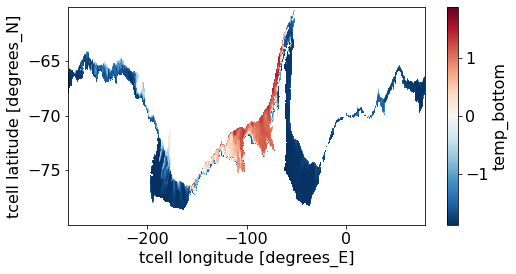

In [116]:
ds.temp_bottom[:,:].plot(figsize=(8,4))
plt.show()

Circumpolar Deep Water (CDW). 

The CDW depth is defined by Schmidtko et al. (2014) as the conservative temperature maximum below the Winter Water depth, where the Winter Water depth is defined as the conservative temperature minimum below 40m depth. So first we need to find the Winter Water depth.

In [18]:
%%time
years = np.arange(1950,1972,1)

for i in range(21):
    loop_yr = years[i]
    print(i, loop_yr)
    access_T_loop = access_T.sel(time=slice(f'{loop_yr}-01-10',f'{loop_yr}-12-20'))
    access_S_loop = access_S.sel(time=slice(f'{loop_yr}-01-10',f'{loop_yr}-12-20'))
    
    # run CDW temp calculation ----------
    print(access_T_loop.time.min().values, access_T_loop.time.max().values)
    
    # first, find the minimum temperature value where st_ocean is > (deeper) than 40m.
    WW_temp = access_T_loop.sel(st_ocean = slice(40,None)).min(dim = 'st_ocean', skipna = True)
    
    # second, mask for all ocean grid cells deeper than the local WW depth. To do this, generate a mask using the above array.
    dept_arr = (WW_temp*0+1)*access_T_loop.st_ocean # creates an array of st_ocean with same dimensions as time, st_ocean, xt_ocean, yt_ocean
    WW_depth = dept_arr.where(access_T_loop == WW_temp) # array with depth where the temp is the WW temp and nans elsewhere
    WW_depth = WW_depth.sel(st_ocean = slice(40, None)).min(dim = 'st_ocean') # shallowest depth where this occurs, deeper than 40m
    below_WW_mask = dept_arr.where(dept_arr > WW_depth) * 0 + 1 # replace depths with 0, except where WW is defined which gets a value of 1
    
    # Now we can get the CDW temperature: the maximum temperature below the WW depth.
    CDW_temp = (access_T_loop * below_WW_mask).max(dim = 'st_ocean', skipna = True).compute()#.mean(dim='time')
    CDW_temp = CDW_temp.where(CDW_temp <= 2.8, np.nan)# Don't use this for now, not stated in paper. 
    
    # Find CDW salinity ------------
    # convert practical salinity to absolute salinity (already done in read-in step)
    #p = gsw.p_from_z(-access_S_loop.st_ocean, access_S_loop.yt_ocean)
    #access_S_loop = gsw.SA_from_SP(access_S_loop, p, access_S_loop.xt_ocean, access_S_loop.yt_ocean)
    
    # Now for salt, we determine the CDW depth at each horizontal grid space and time
    CDW_depth = dept_arr * below_WW_mask
    CDW_depth = CDW_depth.where((access_T_loop * below_WW_mask) == CDW_temp)
    CDW_depth = CDW_depth.min(dim = 'st_ocean')
    
    # then get the salinity at that depth for each grid space and time
    CDW_salt = access_S_loop.where(dept_arr == CDW_depth).sum(dim = 'st_ocean').compute()#.mean(dim='time')
    CDW_salt = CDW_salt.where(CDW_salt > 0, np.nan) # replace zeros with NaNs
    
    # Average over time
    CDW_temp = CDW_temp.mean(dim='time')
    CDW_salt = CDW_salt.mean(dim='time')

    # convert to dataset
    ds = CDW_temp.to_dataset(name = 'temp_cdw')
    ds['salt_cdw'] = CDW_salt
    
    # save to netcdf
    ds.to_netcdf(f'/g/data/e14/hd4873/runs/parcels/output/AntConn/data/bottom_ts/access-om2-01_cdw_TS_ryf_yr_{loop_yr}.nc')

0 1950
1950-01-16 12:00:00 1950-12-16 12:00:00


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

1 1951
1951-01-16 12:00:00 1951-12-16 12:00:00


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


2 1952
1952-01-16 12:00:00 1952-12-16 12:00:00


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


3 1953
1953-01-16 12:00:00 1953-12-16 12:00:00
4 1954
1954-01-16 12:00:00 1954-12-16 12:00:00
5 1955
1955-01-16 12:00:00 1955-12-16 12:00:00
6 1956
1956-01-16 12:00:00 1956-12-16 12:00:00
7 1957
1957-01-16 12:00:00 1957-12-16 12:00:00
8 1958
1958-01-16 12:00:00 1958-12-16 12:00:00
9 1959
1959-01-16 12:00:00 1959-12-16 12:00:00
10 1960
1960-01-16 12:00:00 1960-12-16 12:00:00
11 1961
1961-01-16 12:00:00 1961-12-16 12:00:00
12 1962
1962-01-16 12:00:00 1962-12-16 12:00:00
13 1963
1963-01-16 12:00:00 1963-12-16 12:00:00
14 1964
1964-01-16 12:00:00 1964-12-16 12:00:00
15 1965
1965-01-16 12:00:00 1965-12-16 12:00:00
16 1966
1966-01-16 12:00:00 1966-12-16 12:00:00
17 1967
1967-01-16 12:00:00 1967-12-16 12:00:00
18 1968
1968-01-16 12:00:00 1968-12-16 12:00:00
19 1969
1969-01-16 12:00:00 1969-12-16 12:00:00
20 1970
1970-01-16 12:00:00 1970-12-16 12:00:00


Read in yearly T-S CDW files, average over time and resave. After doing this, delete the yearly files. 

In [19]:
files = sorted(glob('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/bottom_ts/access-om2-01_cdw_TS_ryf_*.nc'))
ds = xr.open_mfdataset(files,concat_dim='year_indx',combine='nested')
ds = ds.mean(dim='year_indx')
ds.to_netcdf(f'/g/data/e14/hd4873/runs/parcels/output/AntConn/data/bottom_ts/access-om2-01_cdw_TS_ryf_1950-1970.nc')
! rm /g/data/e14/hd4873/runs/parcels/output/AntConn/data/bottom_ts/access-om2-01_cdw_TS_ryf_yr_*.nc

#### Read in observational and model data

In [117]:
# Schmidtko et al. (2014)
# [temp] = Conservative Temperature [C]
# [salt] = Absolute Salinity (g/kg)
obsfile = '/g/data/e14/hd4873/obs_data/schmidtkoetal2014/AASW_Temp_Salt.nc'
obs_asbw = xr.open_dataset(obsfile)
obsfile = '/g/data/e14/hd4873/obs_data/schmidtkoetal2014/CDW_Temp_Salt_new.nc'
obs_cdw = xr.open_dataset(obsfile)

modelfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/bottom_ts/access-om2-01_bottom_TS_ryf_1950-1970.nc'
access_asbw = xr.open_dataset(modelfile)
modelfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/bottom_ts/access-om2-01_cdw_TS_ryf_1950-1970.nc'
access_cdw = xr.open_dataset(modelfile)

#### Mask model cdw data

In [119]:
## data required for lat/lon mapping and bathymetry contours
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = (ht*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
yt_ocean =ht.yt_ocean.values
yt_ocean[0]=-90
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = cf.shelf_mask_isobath_tcell(ht)

In [120]:
## create a mask that masks OUT the shelf (opposite of function shelf_mask_isobath)
shelf_mask_new = shelf_mask.where(shelf_mask == 0) + 1
access_cdw = access_cdw * shelf_mask_new

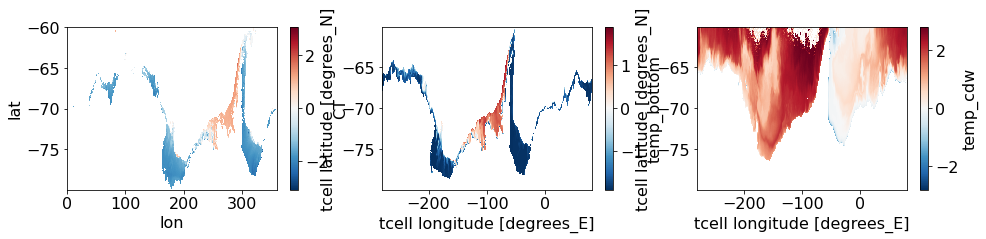

In [121]:
fig,axes = plt.subplots(1,3, figsize=(16,3))
obs_asbw.CT.plot(ax=axes[0])
access_asbw.temp_bottom.plot(ax=axes[1])
access_cdw.temp_cdw.plot(ax=axes[2])
plt.show()

#### Concatenate model data to match obs grid

In [ ]:
# make xt_ocean values from 0 to 180
xt_ocean = access_asbw.xt_ocean.values
xt_ocean[xt_ocean<0] = xt_ocean[xt_ocean<0]+360
# replace xt_ocean coordinate values with these modified xt_ocean values
access_asbw['xt_ocean'] = xt_ocean
access_cdw['xt_ocean'] = xt_ocean
# now concatenate temp and salinity so that it goes from 0 to 360 like schmidtko data
access_asbw_temp = xr.concat((access_asbw.temp_bottom[:,2800:], access_asbw.temp_bottom[:,0:2800]), dim='xt_ocean')
access_asbw_salt = xr.concat((access_asbw.salt_bottom[:,2800:], access_asbw.salt_bottom[:,0:2800]), dim='xt_ocean')
access_cdw_temp = xr.concat((access_cdw.temp_cdw[:,2800:], access_cdw.temp_cdw[:,0:2800]), dim='xt_ocean')
access_cdw_salt = xr.concat((access_cdw.salt_cdw[:,2800:], access_cdw.salt_cdw[:,0:2800]), dim='xt_ocean')
#access_cdw_salt.plot()
#plt.show()

#### Interpolate obs onto model grid

In [28]:
def interp_obs(obs,model_lat,model_lon): 
    obs_new = obs.interp(lat = model_lat, lon = model_lon)
    return obs_new

In [124]:
obs_asbw_access = interp_obs(obs_asbw, access_asbw_temp.yt_ocean.values, access_asbw_temp.xt_ocean.values)
obs_cdw_access = interp_obs(obs_cdw, access_cdw_temp.yt_ocean.values, access_cdw_temp.xt_ocean.values)

#### Define figure functions

In [125]:
## data required for lat/lon mapping and bathymetry contours
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = (ht*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
yt_ocean =ht.yt_ocean.values
yt_ocean[0]=-90
xt_ocean =ht.xt_ocean.values

# define circle 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
subplot_titles = ['Observations from\nSchmidtko et al. (2014)',
                  'ACCESS-OM2-01 \nRYF model years 50-70',
                  'Anomalies','Observations from\nSchmidtko et al. (2014)',
                  'ACCESS-OM2-01 \nRYF model years 50-70',
                  'Anomalies']
subplot_labels = ['a)','b)','c)','d)','e)','f)','g)','h)']
fontsize=16

# define obs land mask
#obs_land_mask = obs_ab.Temp[:,:,0].fillna(1)
#obs_land_mask_masked = obs_land_mask.where(obs_land_mask == 1)

#def subplot_labels(axes):
#    for i, ax in enumerate(axes.flatten()):
#        ax.text()

def map_elements(axes):
    for i, ax in enumerate(axes.flatten()):
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=0.9,zorder=2,transform = ccrs.PlateCarree())
        ax.contourf(xt_ocean, yt_ocean, land_mask_masked.values, [0,1], zorder=2,
                 colors='gainsboro', alpha=1, linewidths=1.2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask.values, [0,1], zorder=3,
                 colors='dimgrey', alpha=1, linewidths=0.9, transform = ccrs.PlateCarree())
        ax.set_extent([-280, 80, -90, -60], ccrs.PlateCarree())
        ax.text(0.1, 0.96, subplot_labels[i],fontsize=20, fontweight='bold',transform = ax.transAxes)
        #ax.set_title(subplot_titles[i],fontsize=14)
        ax.text(0.55, 0.5, subplot_titles[i],fontsize=14,ha='center',va='center',transform = ax.transAxes)
        
def plot_colorbar(fig,axes_loc,cb_item,label,extend='both'):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'vertical',extend = extend, shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=14)
    return cbar


def figure_asbw_cdw_ts_access():
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(2,3,figsize=(18,12),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.02, hspace=0.01)
    map_elements(axes)
    vminT, vmaxT = -2.5, 2.5
    vminS, vmaxS = 34.5, 34.9
    cmapT, cmapS = 'RdBu_r', cmo.cm.haline
    # plot observations
    cb_varT = axes[0,0].pcolormesh(obs_asbw.CT.lon,obs_asbw.CT.lat,obs_asbw.CT,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, 
                   transform = ccrs.PlateCarree())
    axes[0,0].pcolormesh(obs_cdw.CT.lon,obs_cdw.CT.lat,obs_cdw.CT,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, 
                   transform = ccrs.PlateCarree())
    cb_varS = axes[1,0].pcolormesh(obs_asbw.AS.lon,obs_asbw.AS.lat,obs_asbw.AS,
               cmap = cmapS, vmin=vminS, vmax=vmaxS, 
               transform = ccrs.PlateCarree())
    axes[1,0].pcolormesh(obs_cdw.AS.lon,obs_cdw.AS.lat,obs_cdw.AS,
               cmap = cmapS, vmin=vminS, vmax=vmaxS, 
               transform = ccrs.PlateCarree())
    plot_colorbar(fig,[0.07, 0.55, 0.010, 0.3],cb_varT,'ASBW/CDW CT ($^\circ$C)')
    cbarS = plot_colorbar(fig,[0.07, 0.16, 0.010, 0.3],cb_varS,'ASBW/CDW SA (g/kg)')
    cbarS.set_ticks([34.5, 34.6, 34.7, 34.8, 34.9])
    cbarS.set_ticklabels([34.5, 34.6, 34.7, 34.8, 34.9])
    
    return fig, axes
    
# define figure function
def figure_asbw_cdw_ts():
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(2,4,figsize=(23,12),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.02, hspace=0.01)
    map_elements(axes)
    vminT, vmaxT = -2, 2
    vminS, vmaxS = 34.5, 34.9
    cmapT, cmapS = cmo.cm.thermal, cmo.cm.haline
    # plot observations
    cb_varT = axes[0,0].pcolormesh(obs_asbw.CT.lon,obs_asbw.CT.lat,obs_asbw.CT,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, 
                   transform = ccrs.PlateCarree())
    cb_varS = axes[1,0].pcolormesh(obs_asbw.AS.lon,obs_asbw.AS.lat,obs_asbw.AS,
               cmap = cmapS, vmin=vminS, vmax=vmaxS, 
               transform = ccrs.PlateCarree())
    plot_colorbar(fig,[0.08, 0.55, 0.010, 0.3],cb_varT,'ASBW/CDW CT ($^\circ$C)')
    plot_colorbar(fig,[0.08, 0.16, 0.010, 0.3],cb_varS,'ASBW/CDW SA (g/kg)')
    return fig, axes

#### Plot figures

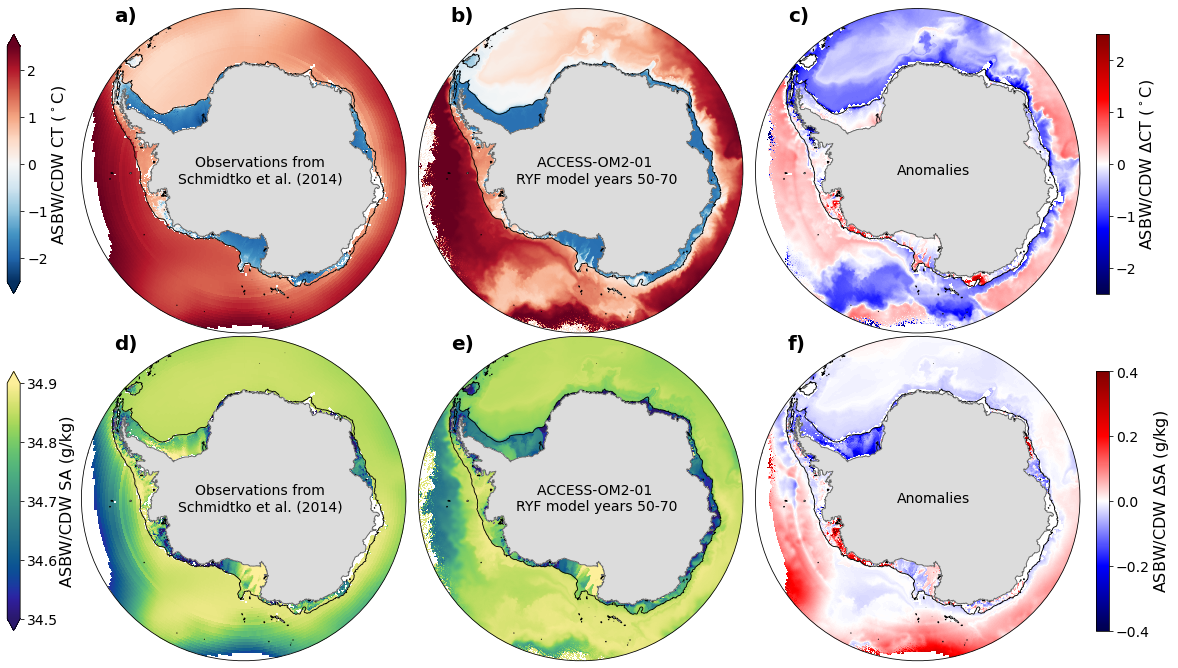

In [127]:
fig, axes = figure_asbw_cdw_ts_access()
cmapT,cmapS, cmapA = 'RdBu_r', cmo.cm.haline, 'seismic'
vminT, vmaxT = -2.5, 2.5
vminS, vmaxS = 34.5, 34.9
vminSa, vmaxSa = -0.4, 0.4

# plot access temp field
axes[0,1].pcolormesh(access_asbw_temp.xt_ocean,access_asbw_temp.yt_ocean,access_asbw_temp,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, transform = ccrs.PlateCarree(),zorder=1)
axes[0,1].pcolormesh(access_cdw_temp.xt_ocean,access_cdw_temp.yt_ocean,access_cdw_temp,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, transform = ccrs.PlateCarree(),zorder=1)

# plot access salt field
axes[1,1].pcolormesh(access_asbw_salt.xt_ocean,access_asbw_salt.yt_ocean,access_asbw_salt,
                   cmap = cmapS, vmin=vminS, vmax=vmaxS, transform = ccrs.PlateCarree(),zorder=1)
axes[1,1].pcolormesh(access_cdw_salt.xt_ocean,access_cdw_salt.yt_ocean,access_cdw_salt,
                   cmap = cmapS, vmin=vminS, vmax=vmaxS, transform = ccrs.PlateCarree(),zorder=1)


# plot anomalies from climatology
anom_asbw_T = access_asbw_temp - obs_asbw_access.CT.values
anom_cdw_T = access_cdw_temp - obs_cdw_access.CT.values
anom_asbw_S = access_asbw_salt - obs_asbw_access.AS.values
anom_cdw_S = access_cdw_salt - obs_cdw_access.AS.values

cb_anomT = axes[0][2].pcolormesh(anom_asbw_T.xt_ocean,anom_asbw_T.yt_ocean,anom_asbw_T,
                   cmap = cmapA, vmin=vminT, vmax=vmaxT, transform = ccrs.PlateCarree())
axes[0][2].pcolormesh(anom_cdw_T.xt_ocean,anom_cdw_T.yt_ocean,anom_cdw_T,
                   cmap = cmapA, vmin=vminT, vmax=vmaxT, transform = ccrs.PlateCarree())
cb_anomS = axes[1][2].pcolormesh(anom_asbw_S.xt_ocean,anom_asbw_S.yt_ocean,anom_asbw_S,
                   cmap = cmapA, vmin=vminSa, vmax=vmaxSa, transform = ccrs.PlateCarree())
axes[1][2].pcolormesh(anom_cdw_S.xt_ocean,anom_cdw_S.yt_ocean,anom_cdw_S,
                   cmap = cmapA, vmin=vminSa, vmax=vmaxSa, transform = ccrs.PlateCarree())

cbT = plot_colorbar(fig,[0.91, 0.55, 0.01, 0.3],cb_anomT,'ASBW/CDW $\Delta$CT ($^\circ$C)',extend='neither')
cbS = plot_colorbar(fig,[0.91, 0.16, 0.01, 0.3],cb_anomS,'ASBW/CDW $\Delta$SA (g/kg)',extend='neither')

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbS.ax.set_yticks([-0.4, -0.2, 0, 0.2, 0.4]) 
#cbS.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
plt.show()

figfilename = f'/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/model_obs_ASBW-CDW_comparison_access_only.jpg'
fig.savefig(figfilename, bbox_inches='tight', dpi=200)

In [128]:
subplot_titles = ['ACCESS-OM2-01 \nRYF model years 50-70',
                  'Observations from\nSchmidtko et al. (2014)',
                  'Anomalies\n(model - observed)']

def plot_colorbar(fig,axes_loc,cb_item,label,extend='both'):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'vertical',extend = extend)
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=14)
    return cbar

def figure_asbw_cdw_ts_access():
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(1,3,figsize=(18,6),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    map_elements(axes)
    vminT, vmaxT = -2, 2
    vminS, vmaxS = 34.5, 34.9
    cmapT, cmapS = 'RdBu_r', cmo.cm.haline
    # plot model asbw
    axes[0].pcolormesh(access_asbw_temp.xt_ocean,access_asbw_temp.yt_ocean,access_asbw_temp,
               cmap = cmapT, vmin=vminT, vmax=vmaxT, transform = ccrs.PlateCarree(),zorder=1)
    # plot observations
    cb_varT = axes[1].pcolormesh(obs_asbw.CT.lon,obs_asbw.CT.lat,obs_asbw.CT,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, 
                   transform = ccrs.PlateCarree())
    # plot anomalies
    anom_asbw_T = access_asbw_temp - obs_asbw_access.CT.values
    cb_anomT = axes[2].pcolormesh(anom_asbw_T.xt_ocean,anom_asbw_T.yt_ocean,anom_asbw_T,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, transform = ccrs.PlateCarree())

    plot_colorbar(fig,[0.91, 0.2, 0.010, 0.6],cb_varT,'ASBW CT ($^\circ$C)',extend='neither')
    return fig, axes

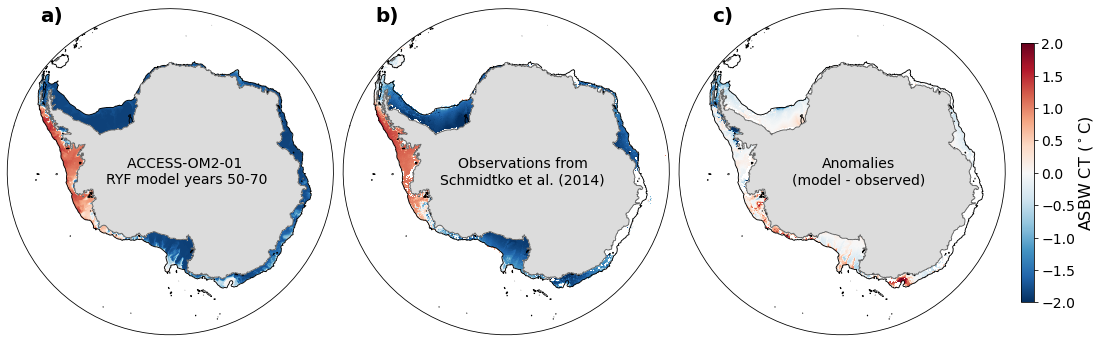

In [129]:
fig, axes = figure_asbw_cdw_ts_access()

figfilename = f'/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/model_obs_ASBW_comparison_access_only.jpg'
fig.savefig(figfilename, bbox_inches='tight', dpi=200)